# Property cost in Cape Town
The purpose of this notebook is to analyse and predict the cost of different properties in Cape Town. To do this I first scrape some data from Property24, preprocess it, fill the missing values and then use several machine learning models to predict the price. Let's dive into the analysis!

In [2]:
# Import needed libraries and functions
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import preprocess_data
from size import predict_property_size
from predict import predict_price
from predict_your_price import predict_your_price

First, I import the preprocessed data and print out the first few lines and some statistics to understand the structure and content of the data.

The code used to fetch the data and preprocess it is available in the `data.py` and `preprocessing.py` files, respectively.

In [3]:
data = preprocess_data()

# Print the first few lines of the data
print("First few lines of the data:")
print(data.head())

# Print the summary statistics of the data
print("\nSummary statistics of the data:")
print(data.describe())

First few lines of the data:
          Price  Bedrooms  Bathrooms   Size
8    84775.7640       3.0        2.0  135.0
9   119986.4648       4.0        2.0  420.0
10   97529.6400       2.0        1.0   82.0
11  124787.9240       1.0        1.0  324.0
13  117535.7200       1.0        1.0   66.0

Summary statistics of the data:
               Price     Bedrooms    Bathrooms         Size
count    7131.000000  7131.000000  7131.000000  6608.000000
mean   184917.643595     2.254803     1.595499   291.752494
std    176701.641791     1.090506     0.814616   581.647069
min      4951.504800     0.500000     0.500000     1.000000
25%     75022.749985     2.000000     1.000000    61.000000
50%    119786.404000     2.000000     1.000000   107.000000
75%    219816.804000     3.000000     2.000000   317.000000
max    950288.800000     6.000000     4.500000  9105.000000


The 'Size' column has some missing values (indicated by the count being lower than in other variables). To address this, I will fill the missing values by using the average predictions from several machine learning models. Note that I will be using the entire dataset to train these models, which is not the best practice in machine learning because it can lead to data leakage. However, for simplicity, I will proceed with this approach here.

But first, let's visualize our data so we know what we are dealing with.

### DATA VISUALIZATION
In this section, I'll be visualizing the data to uncover patterns and insights for better understanding and analysis.

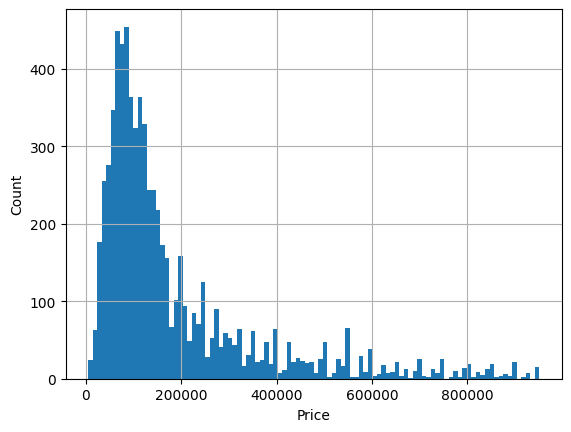

In [4]:
# Plot the histogram of apartment/house prices
data['Price'].hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

We can see that the majority of the properties cost around 100,000 euros.

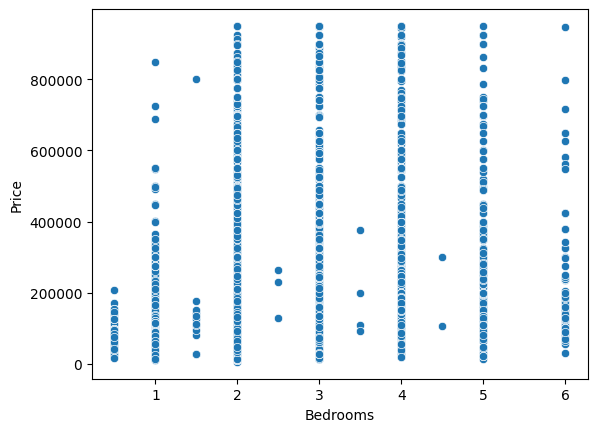

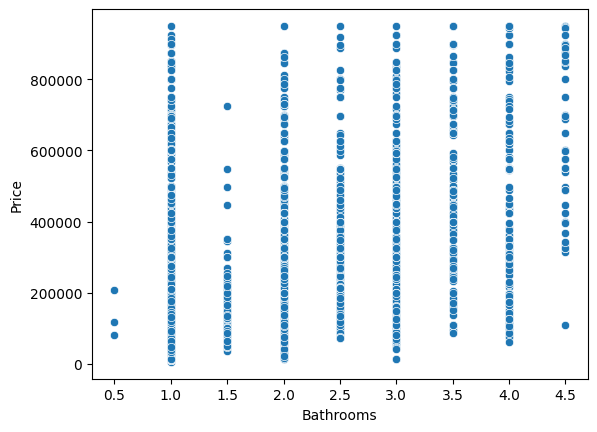

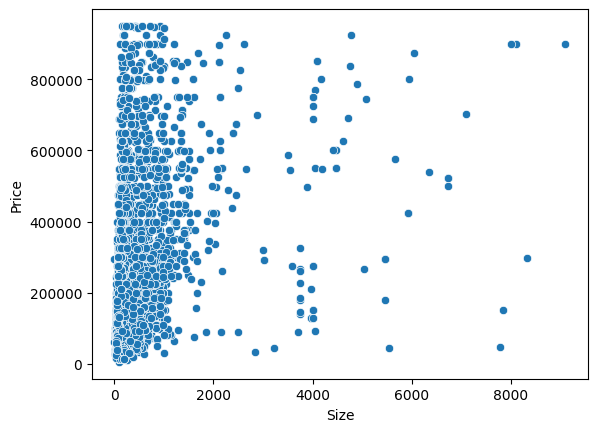

In [5]:
# Plot scatterplots of price against each independent variable
column_names = data.columns
for i, col in enumerate(column_names[1:]):
    plt.figure(i)
    sns.scatterplot(data, x=str(col), y='Price')
# Note that the size variable some NaN values

After examining these scatter plots, there don't appear to be any notable relationships between the price of the property and its size, number of bedrooms, or number of bathrooms.

From this, we can conclude that we might need additional variables, such as the age of the property or its location, to better predict the price.

### FILLING MISSING SIZE VALUES

Now let's address the mentioned missing values in the 'Size' column. To do this, I first isolate the rows with the missing 'Size' variable and then train three models to predict the size of the property. The predictions for each of the models can be seen in the scatter plots below. Finally, I calculate the mean of predictions from all of the models to determine the 'correct' value, which will be used for price prediction later on. The 'correct' values are visualized in the last plot.

For the code implementation, please view the `size.py` document.


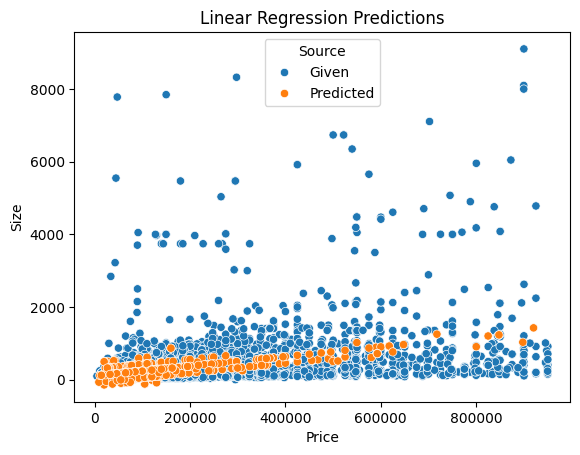

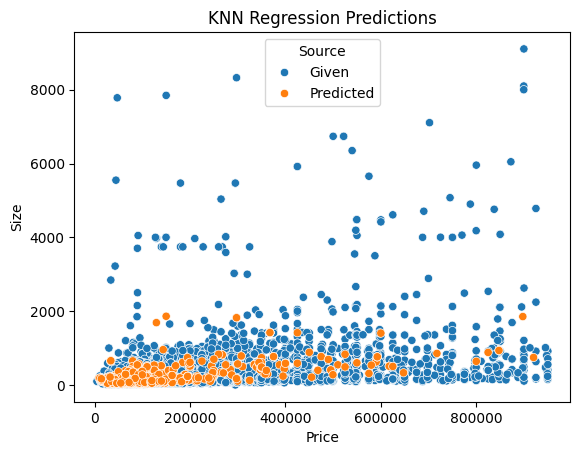

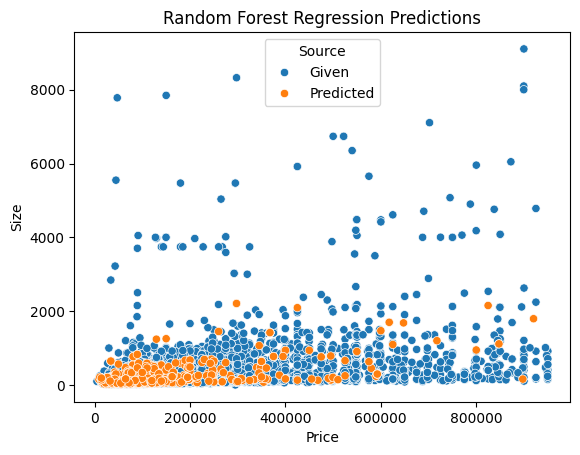

Scatter plot of 'correct' values:


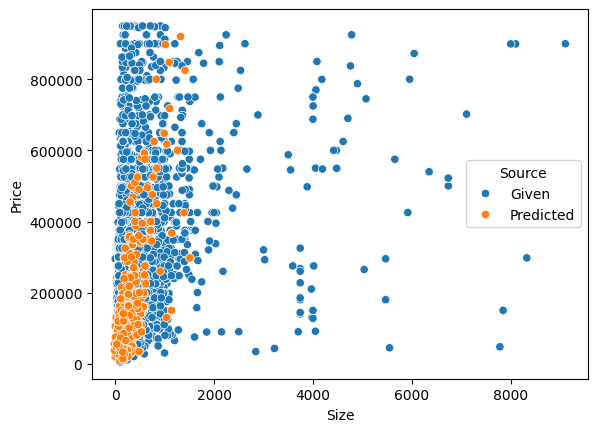

In [6]:
data_full = predict_property_size(data)

### MODEL TRAINING FOR PRICE PREDICTION

In this section, I train and test multiple machine learning models (linear regression, KNN regression, random forest regression) using k-fold cross-validation with 5 splits to predict the price of the property. I evaluate their performance using various subsets of my data. The code for this process is available in the `predict.py` file.

In [7]:
predict_price(data_full)

Full dataset:
Mean RMSE Linear Regression: 141339.96486790307
Mean RMSE KNN Regression: 141702.08834617108
Mean RMSE Random Forest Regression: 129982.28564576483

Dataset with dummy variables:
Mean RMSE Linear Regression: 137330.60421643747
Mean RMSE KNN Regression: 146222.8263246892
Mean RMSE Random Forest Regression: 130242.17411419102

Dataset with standardised 'Size' column:
Mean RMSE Linear Regression: 140949.7101217568
Mean RMSE KNN Regression: 129464.08882956824
Mean RMSE Random Forest Regression: 130991.99899479366

Dataset without the 'Size' column:
Mean RMSE Linear Regression: 152256.9444919834
Mean RMSE KNN Regression: 157865.2700747721
Mean RMSE Random Forest Regression: 147275.4719900217

Dataset with only the 'Size' column:
Mean RMSE Linear Regression: 162616.13810485805
Mean RMSE KNN Regression: 156242.17227909312
Mean RMSE Random Forest Regression: 158667.14654094554


Based on the mean RMSE values obtained from our analysis, it is evident that all models across different datasets exhibit higher errors than desired. Specifically, the mean RMSE from our models averages around 140,000€. This indicates that, on average, the models predict the price of the property with a 140,000€ margin of error, which is significant considering the mean property price is 180,000€. While the limited set of prediction variables may contribute to these results, further analysis is essential to gain a deeper understanding of each model's performance. Additional investigation could involve exploring feature importance, optimizing model hyperparameters, and potentially gathering more data to improve model generalization. These insights would be crucial in refining our predictive models for more accurate outcomes.

### PRICE PREDICTION FROM GIVEN VARIABLES

Using the dataset with the standardized 'Size' column, which on average performed the best, I have created a function that allows you to specify the size (in square meters), number of bedrooms and bathrooms to obtain a predicted price for that type of property. The predicted price will be the mean of predictions from all three models used above and all folds in the k-fold cross-validation process. The code of this function is available in the `predict_your_price.py` file.

In [10]:
# Feel free to change these parameters, just be sure that the second two are integers
size = 60 # Value in m²
bedrooms = 1
bathrooms = 1

predicted_price = predict_your_price(data_full, size, bathrooms, bedrooms)
print(f'Size: {size}m², No. bedrooms: {bedrooms}, No. bathrooms: {bathrooms}, Predicted price: {predicted_price}€')

Size: 60m², No. bedrooms: 1, No. bathrooms: 1, Predicted price: 109498.03577750812€
